## Dependencies

In [1]:
import pandas
%pip install pandas
%pip install fastparquet
%pip install tensorflow
%pip install matplotlib
%pip install numpy
%pip install keras
%pip install pydot
%pip install seaborn

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


## Setup

In [2]:
import re
import os
import random
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.utils import class_weight
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import wandb
from wandb.keras import WandbCallback

## Import and preprocess data

In [3]:
df = pd.read_parquet("data/Thermo_SRM_Pool_meta_data.parquet", engine='fastparquet')

In [4]:
print(df.shape)
print(df.head(4))
print(df.columns)

(6080606, 15)
                                       raw_file  scan_number  \
0  01640c_BC1-Thermo_SRM_Pool_3_01_01-DDA-1h-R2        34736   
1  01640c_BC1-Thermo_SRM_Pool_3_01_01-DDA-1h-R2        25591   
2  01640c_BC1-Thermo_SRM_Pool_3_01_01-DDA-1h-R2        24831   
3  01640c_BC1-Thermo_SRM_Pool_3_01_01-DDA-1h-R2        34870   

      modified_sequence  precursor_charge  precursor_intensity          mz  \
0  LPGSLETYVEQEQGENANDR                 2           29525630.0  1125.01950   
1       HGSLQEYLQNDTGSK                 2           13188580.0   838.89737   
2        VEEEEEINSELTAR                 2           20663460.0   824.38904   
3  LPGSLETYVEQEQGENANDR                 2           19884630.0  1125.01950   

   precursor_mz fragmentation mass_analyzer  retention_time  \
0   1125.018331           CID          ITMS          38.411   
1    838.894401           HCD          FTMS          30.394   
2    824.388401           CID          ITMS          29.737   
3   1125.018831       

### Check what charge states are in the data

In [5]:
list_charge = df["precursor_charge"].unique().tolist()
print(sorted(list_charge))

[1, 2, 3, 4, 5, 6, 7]


### Create dataframe containing only sequence and precursor charge as well as the precursor intensity

In [6]:
# drop all columns we don't need for training
for column in df.columns:
    if column not in ["modified_sequence", "precursor_charge", 'precursor_intensity']:
        df.drop(column, axis=1, inplace=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6080606 entries, 0 to 6080605
Data columns (total 3 columns):
 #   Column               Dtype  
---  ------               -----  
 0   modified_sequence    object 
 1   precursor_charge     int64  
 2   precursor_intensity  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 139.2+ MB


## Find all unique UNIMOD annotations

In [7]:
# Extract the unique amino acids with UNIMOD annotations
annotations = re.findall(r'(\w\[UNIMOD:\d+\])', ' '.join(df['modified_sequence']))
unique_combinations = list(set(annotations))

# Count the occurrences of each unique annotation
occurrences = {combination: annotations.count(combination) for combination in unique_combinations}

# Extract the amino acids affected by the unique combinations
affected_amino_acids = set([combination[0] for combination in unique_combinations])

# Print the unique amino acids with UNIMOD annotations and their occurrences
for combination in unique_combinations:
    print(f"Annotation: {combination}, Occurrences: {occurrences[combination]}")

Annotation: M[UNIMOD:35], Occurrences: 861764
Annotation: C[UNIMOD:4], Occurrences: 662343


In [8]:
unique_combinations

['M[UNIMOD:35]', 'C[UNIMOD:4]']

### Delete the one SeptupleCharge from the set

In [9]:
print(len(df))

6080606


In [10]:
def delete_entries_with_charge_7(dataframe):
    # Filter the dataframe to keep only entries with precursor charge not equal to 7
    filtered_df = dataframe[dataframe['precursor_charge'] != 7]

    return filtered_df

In [11]:
df_filtered = delete_entries_with_charge_7(df)

In [12]:
print(len(df_filtered))

6080604


### Convert protein sequences to numerical representation

In [13]:
amino_acids = list('ACDEFGHIKLMNPQRSTVWY')  # List of amino acids

# Convert modified sequences to numerical representation
def sequence_to_vector(sequence):
    vector = []
    i = 0
    while i < len(sequence):
        # normal aminoacids
        char = sequence[i]
        if char in amino_acids:
            vector.append(amino_acids.index(char))
        # handle UNIMOD annotated aminoacids
        elif char == '[':
            annotation_end = sequence.index(']', i)
            modifier = sequence[i-1:annotation_end + 1]
            if modifier in unique_combinations:
                # change value of last assigned aminoacid to modified index
                vector[-1] = (len(amino_acids) + unique_combinations.index(modifier))
                i = annotation_end
            else:
                raise ValueError(f"Invalid UNIMOD annotation found in sequence: {modifier}")
        else:
            raise ValueError(f"Invalid character found in sequence: {char}")
        i += 1
    return vector

df_filtered['sequence_vector'] = df_filtered['modified_sequence'].apply(sequence_to_vector)
df_filtered

C:\Users\Florian\AppData\Local\Temp\ipykernel_23648\2499720789.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['sequence_vector'] = df_filtered['modified_sequence'].apply(sequence_to_vector)


,modified_sequence,precursor_charge,precursor_intensity,sequence_vector
0,LPGSLETYVEQEQGENANDR,2,29525630.0,"[9, 12, 5, 15, 9, 3, 16, 19, 17, 3, 13, 3, 13,..."
1,HGSLQEYLQNDTGSK,2,13188580.0,"[6, 5, 15, 9, 13, 3, 19, 9, 13, 11, 2, 16, 5, ..."
2,VEEEEEINSELTAR,2,20663460.0,"[17, 3, 3, 3, 3, 3, 7, 11, 15, 3, 9, 16, 0, 14]"
3,LPGSLETYVEQEQGENANDR,2,19884630.0,"[9, 12, 5, 15, 9, 3, 16, 19, 17, 3, 13, 3, 13,..."
4,NSSTAEINETTTSSTDFLAR,2,12804420.0,"[11, 15, 15, 16, 0, 3, 7, 11, 3, 16, 16, 16, 1..."
...,...,...,...,...
6080601,YSQLFC[UNIMOD:4]GLPSLHSESLVATFMGSQGLPK,3,573697.7,"[19, 15, 13, 9, 4, 21, 5, 9, 12, 15, 9, 6, 15,..."
6080602,YSQLFC[UNIMOD:4]GLPSLHSESLVATFMGSQGLPK,3,573697.7,"[19, 15, 13, 9, 4, 21, 5, 9, 12, 15, 9, 6, 15,..."
6080603,EMENFVQSSGEDGIVVFSLGSLFQNVTEEK,3,114742.8,"[3, 10, 3, 11, 4, 17, 13, 15, 15, 5, 3, 2, 5, ..."
6080604,EMENFVQSSGEDGIVVFSLGSLFQNVTEEK,3,114742.8,"[3, 10, 3, 11, 4, 17, 13, 15, 15, 5, 3, 2, 5, ..."


### Pad sequence_vectors to the max sequence length

In [14]:
def pad_sequences(dataframe, column_name, pad_value=50):
    max_len = max(dataframe.loc[:, column_name].apply(len))  # Find the maximum length
    dataframe.loc[:, column_name] = dataframe.loc[:, column_name].apply(lambda x: x + [pad_value] * (max_len - len(x)))  # Pad the sequences
    return max_len, dataframe

In [15]:
max_len, df_filtered_padded = pad_sequences(df_filtered, 'sequence_vector')

C:\Users\Florian\AppData\Local\Temp\ipykernel_23648\2264715427.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe.loc[:, column_name] = dataframe.loc[:, column_name].apply(lambda x: x + [pad_value] * (max_len - len(x)))  # Pad the sequences


In [16]:
max_len

42

In [17]:
df_filtered_padded

,modified_sequence,precursor_charge,precursor_intensity,sequence_vector
0,LPGSLETYVEQEQGENANDR,2,29525630.0,"[9, 12, 5, 15, 9, 3, 16, 19, 17, 3, 13, 3, 13,..."
1,HGSLQEYLQNDTGSK,2,13188580.0,"[6, 5, 15, 9, 13, 3, 19, 9, 13, 11, 2, 16, 5, ..."
2,VEEEEEINSELTAR,2,20663460.0,"[17, 3, 3, 3, 3, 3, 7, 11, 15, 3, 9, 16, 0, 14..."
3,LPGSLETYVEQEQGENANDR,2,19884630.0,"[9, 12, 5, 15, 9, 3, 16, 19, 17, 3, 13, 3, 13,..."
4,NSSTAEINETTTSSTDFLAR,2,12804420.0,"[11, 15, 15, 16, 0, 3, 7, 11, 3, 16, 16, 16, 1..."
...,...,...,...,...
6080601,YSQLFC[UNIMOD:4]GLPSLHSESLVATFMGSQGLPK,3,573697.7,"[19, 15, 13, 9, 4, 21, 5, 9, 12, 15, 9, 6, 15,..."
6080602,YSQLFC[UNIMOD:4]GLPSLHSESLVATFMGSQGLPK,3,573697.7,"[19, 15, 13, 9, 4, 21, 5, 9, 12, 15, 9, 6, 15,..."
6080603,EMENFVQSSGEDGIVVFSLGSLFQNVTEEK,3,114742.8,"[3, 10, 3, 11, 4, 17, 13, 15, 15, 5, 3, 2, 5, ..."
6080604,EMENFVQSSGEDGIVVFSLGSLFQNVTEEK,3,114742.8,"[3, 10, 3, 11, 4, 17, 13, 15, 15, 5, 3, 2, 5, ..."


### Keep only the most common charge state for a given sequence
### take precursor intensity into account

In [19]:
# print the highest and lowest value for precursor_intensity
highest_value = df['precursor_intensity'].max()
lowest_value = df['precursor_intensity'].min()

print("Highest precursor intensity:", highest_value)
print("Lowest precursor intensity:", lowest_value)

Highest precursor intensity: 18818740000.0
Lowest precursor intensity: 13496.65


In [21]:
def filter_highest_precursor_intensity(df):
    # Group the DataFrame by 'modified_sequence' and 'precursor_charge' and find the index corresponding to the highest 'precursor_intensity' in each group
    idx = df.groupby(['modified_sequence', 'precursor_charge'])['precursor_intensity'].idxmax()

    # Select the rows with the highest 'precursor_intensity' for each group
    filtered_df = df.loc[idx]

    return filtered_df

df_filtered_padded_highest_intensity = filter_highest_precursor_intensity(df_filtered_padded)
df_filtered_padded_highest_intensity

KeyError: '[nan] not in index'

## PROBLEM: not all sequences show precursor intensity value

In [22]:
nan_rows = df_filtered_padded[df_filtered_padded.isnull().any(axis=1)]
print(nan_rows)

                               modified_sequence  precursor_charge  \
370                               HEESSWGGSPSPVR                 2   
406                               HEESSWGGSPSPVR                 2   
455                                YEEQQLEIQNSSR                 2   
474                           LFNTSVEVLPFDNPQSDK                 2   
639                                 FESLLTDQTLWR                 2   
...                                          ...               ...   
6080592              DGSPLLGGC[UNIMOD:4]SDSSGSLR                 2   
6080594                             HGIGSLLLESLK                 3   
6080598  LTVHGFVNPTSFVYGSNDENEPETC[UNIMOD:4]MVEK                 3   
6080599                        ALEAENSALALENENQR                 2   
6080600                        ALEAENSALALENENQR                 2   

         precursor_intensity  \
370                      NaN   
406                      NaN   
455                      NaN   
474                      NaN   

In [120]:
def keep_unique_most_common_sequence(dataframe):
    # Group the dataframe by 'modified_sequence' and find the most common precursor charge for each group
    grouped_df = dataframe.groupby('modified_sequence')['precursor_charge'].agg(lambda x: x.value_counts().idxmax())

    # Reset the index to convert the grouped series back to a dataframe
    grouped_df = grouped_df.reset_index()

    # keep only the most common charge entries
    merged_df = dataframe.merge(grouped_df, on=['modified_sequence', 'precursor_charge'])

    # Drop duplicate rows based on 'modified_sequence'
    unique_df = merged_df.drop_duplicates(subset=['modified_sequence'])

    # Return the unique dataframe
    return unique_df

In [121]:
df_mostCommonCharge = keep_unique_most_common_sequence(df_filtered_padded)
df_mostCommonCharge

,modified_sequence,precursor_charge,sequence_vector
0,LPGSLETYVEQEQGENANDR,2,"[9, 12, 5, 15, 9, 3, 16, 19, 17, 3, 13, 3, 13,..."
41,VEEEEEINSELTAR,2,"[17, 3, 3, 3, 3, 3, 7, 11, 15, 3, 9, 16, 0, 14..."
944,NSSTAEINETTTSSTDFLAR,2,"[11, 15, 15, 16, 0, 3, 7, 11, 3, 16, 16, 16, 1..."
963,SELGSFITDYFQNQLLAK,2,"[15, 3, 9, 5, 15, 4, 7, 16, 2, 19, 4, 13, 11, ..."
983,ETTGAQVQVAGDLLPNSTER,2,"[3, 16, 16, 5, 0, 13, 17, 13, 17, 0, 5, 2, 9, ..."
...,...,...,...
4215475,ALPGAADLRPK,2,"[0, 9, 12, 5, 0, 0, 2, 9, 14, 12, 8, 21, 21, 2..."
4215482,NIWDQATHLQK,2,"[11, 7, 18, 2, 13, 0, 16, 6, 9, 13, 8, 21, 21,..."
4215483,LQDELSDVIDIKEAEEVISSSTK,4,"[9, 13, 2, 3, 9, 15, 2, 17, 7, 2, 7, 8, 3, 0, ..."
4215484,FDDVWPMDPHPR,3,"[4, 2, 2, 17, 18, 12, 10, 2, 12, 6, 12, 14, 21..."


In [123]:
print(len(df_mostCommonCharge))

49666


### Sparse_categorical_crossentropy with unique sequences

In [122]:
# Initialize Weights and Biases
# wandb.init(project='precursor_charge_prediction')

In [124]:
# Split the data into train, validation, and test sets
X = np.array(df_mostCommonCharge['sequence_vector'].tolist())
y = np.array(df_mostCommonCharge['precursor_charge'])
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42) # splits X/y_train_val in X/y_train and X/y_val

### Stratified split won't work as there is only one entry for the Septuple_charges
# Create an instance of StratifiedShuffleSplit
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

# Perform the split
train_val_indices, test_indices = next(sss.split(X, y))
X_train_val, X_test = X[train_val_indices], X[test_indices]
y_train_val, y_test = y[train_val_indices], y[test_indices]

# Create another instance of StratifiedShuffleSplit for train-validation split
sss_train_val = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

# Perform the train-validation split
train_indices, val_indices = next(sss_train_val.split(X_train_val, y_train_val))
X_train, X_val = X_train_val[train_indices], X_train_val[val_indices]
y_train, y_val = y_train_val[train_indices], y_train_val[val_indices]


# Define model
model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(input_dim=max_len, output_dim=20, input_length=X.shape[1]),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(8, activation='softmax')
])

# Compile the model
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [126]:
# Configure Weights and Biases callback
checkpoint_callback = ModelCheckpoint('precursor_charge_prediction_model_v1/sparse_cce_uniqe_wo7.h5', monitor='val_accuracy', save_best_only=True, mode='max')
# wandb_callback = WandbCallback()

In [127]:
# Define early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

In [128]:
# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val), callbacks=[checkpoint_callback, early_stopping]) #, wandb_callback])

Epoch 1/10
994/994 [==============================] - 3s 2ms/step - loss: 0.3941 - accuracy: 0.8480 - val_loss: 0.2886 - val_accuracy: 0.8856
Epoch 2/10
994/994 [==============================] - 2s 2ms/step - loss: 0.2665 - accuracy: 0.9000 - val_loss: 0.2600 - val_accuracy: 0.9034
Epoch 3/10
994/994 [==============================] - 2s 2ms/step - loss: 0.2549 - accuracy: 0.9050 - val_loss: 0.2589 - val_accuracy: 0.9032
Epoch 4/10
994/994 [==============================] - 2s 2ms/step - loss: 0.2493 - accuracy: 0.9066 - val_loss: 0.2608 - val_accuracy: 0.9065
Epoch 5/10
994/994 [==============================] - 2s 2ms/step - loss: 0.2424 - accuracy: 0.9099 - val_loss: 0.2586 - val_accuracy: 0.9055
Epoch 6/10
994/994 [==============================] - 2s 2ms/step - loss: 0.2375 - accuracy: 0.9111 - val_loss: 0.2589 - val_accuracy: 0.9059
Epoch 7/10
994/994 [==============================] - 2s 2ms/step - loss: 0.2322 - accuracy: 0.9134 - val_loss: 0.2594 - val_accuracy: 0.9063
Epoch 

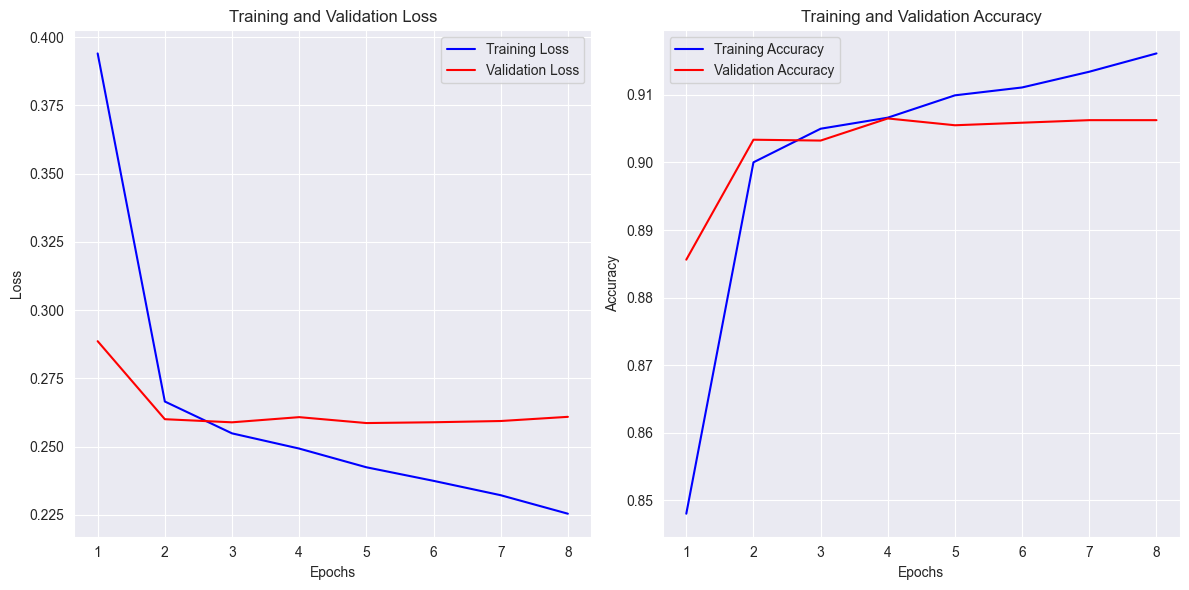

In [129]:
# Access the loss, validation loss, and accuracy from the history object
loss = history.history['loss']
val_loss = history.history['val_loss']
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Plot the loss, validation loss, and accuracy curves
epochs = range(1, len(loss) + 1)

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot loss and validation loss
ax1.plot(epochs, loss, 'b', label='Training Loss')
ax1.plot(epochs, val_loss, 'r', label='Validation Loss')
ax1.set_title('Training and Validation Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()

# Plot accuracy and validation accuracy
ax2.plot(epochs, accuracy, 'b', label='Training Accuracy')
ax2.plot(epochs, val_accuracy, 'r', label='Validation Accuracy')
ax2.set_title('Training and Validation Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()

# Adjust spacing between subplots
plt.tight_layout()

# Show the plots
plt.show()

In [78]:
best_model.save('precursor_charge_prediction_model_v1')

INFO:tensorflow:Assets written to: precursor_charge_prediction_model_v1\assets


INFO:tensorflow:Assets written to: precursor_charge_prediction_model_v1\assets


### Categorical_crossentropy with all sequences

In [136]:
# Split the data into train, validation, and test sets
X_2 = np.array(df_filtered_padded['sequence_vector'].tolist())
y_2 = np.array(df_filtered_padded['precursor_charge'])

# Create an instance of StratifiedShuffleSplit
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

# Perform the split
train_val_indices, test_indices = next(sss.split(X_2, y_2))
X_2_train_val, X_2_test = X_2[train_val_indices], X_2[test_indices]
y_2_train_val, y_2_test = y_2[train_val_indices], y_2[test_indices]

# Create another instance of StratifiedShuffleSplit for train-validation split
sss_train_val = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

# Perform the train-validation split
train_indices, val_indices = next(sss_train_val.split(X_2_train_val, y_2_train_val))
X_2_train, X_2_val = X_2_train_val[train_indices], X_2_train_val[val_indices]
y_2_train, y_2_val = y_2_train_val[train_indices], y_2_train_val[val_indices]

num_classes = 8  # Number of precursor charge classes (1 to 7, plus an extra class for 'None' charge)
y_2_train_encoded = tf.keras.utils.to_categorical(y_2_train, num_classes)
y_2_val_encoded = tf.keras.utils.to_categorical(y_2_val, num_classes)
y_2_test_encoded = tf.keras.utils.to_categorical(y_2_train, num_classes)

# Define model
model_cce = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(input_dim=max_len, output_dim=20, input_length=X_2.shape[1]),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

# Compile the model
model_cce.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [77]:
# Load the best model
best_model = tf.keras.models.load_model('precursor_charge_prediction_model_v1/best_model.h5')

# Evaluate the best model
loss, accuracy = best_model.evaluate(X_test, y_test)
print('Accuracy:', accuracy)

# Save the best model to Weights and Biases
# wandb.save('best_model.h5')

29759/29759 [==============================] - 32s 1ms/step - loss: 0.2620 - accuracy: 0.8751
Accuracy: 0.8750681281089783


In [137]:
checkpoint_callback = ModelCheckpoint('precursor_charge_prediction_model_v1/cce_wo7_allSequences.h5', monitor='val_accuracy', save_best_only=True, mode='max')

In [138]:
# Train the model
history_cce = model_cce.fit(X_2_train, y_2_train_encoded, epochs=10, batch_size=32, validation_data=(X_2_val, y_2_val_encoded), callbacks=[checkpoint_callback, early_stopping]) #, wandb_callback])

Epoch 1/10
95229/95229 [==============================] - 168s 2ms/step - loss: 0.2933 - accuracy: 0.8625 - val_loss: 0.2793 - val_accuracy: 0.8692
Epoch 2/10
95229/95229 [==============================] - 171s 2ms/step - loss: 0.2732 - accuracy: 0.8710 - val_loss: 0.2714 - val_accuracy: 0.8708
Epoch 3/10
95229/95229 [==============================] - 164s 2ms/step - loss: 0.2676 - accuracy: 0.8730 - val_loss: 0.2687 - val_accuracy: 0.8729
Epoch 4/10
95229/95229 [==============================] - 168s 2ms/step - loss: 0.2649 - accuracy: 0.8741 - val_loss: 0.2656 - val_accuracy: 0.8738
Epoch 5/10
95229/95229 [==============================] - 169s 2ms/step - loss: 0.2631 - accuracy: 0.8744 - val_loss: 0.2666 - val_accuracy: 0.8742
Epoch 6/10
95229/95229 [==============================] - 166s 2ms/step - loss: 0.2619 - accuracy: 0.8750 - val_loss: 0.2648 - val_accuracy: 0.8745
Epoch 7/10
95229/95229 [==============================] - 170s 2ms/step - loss: 0.2614 - accuracy: 0.8752 - val_

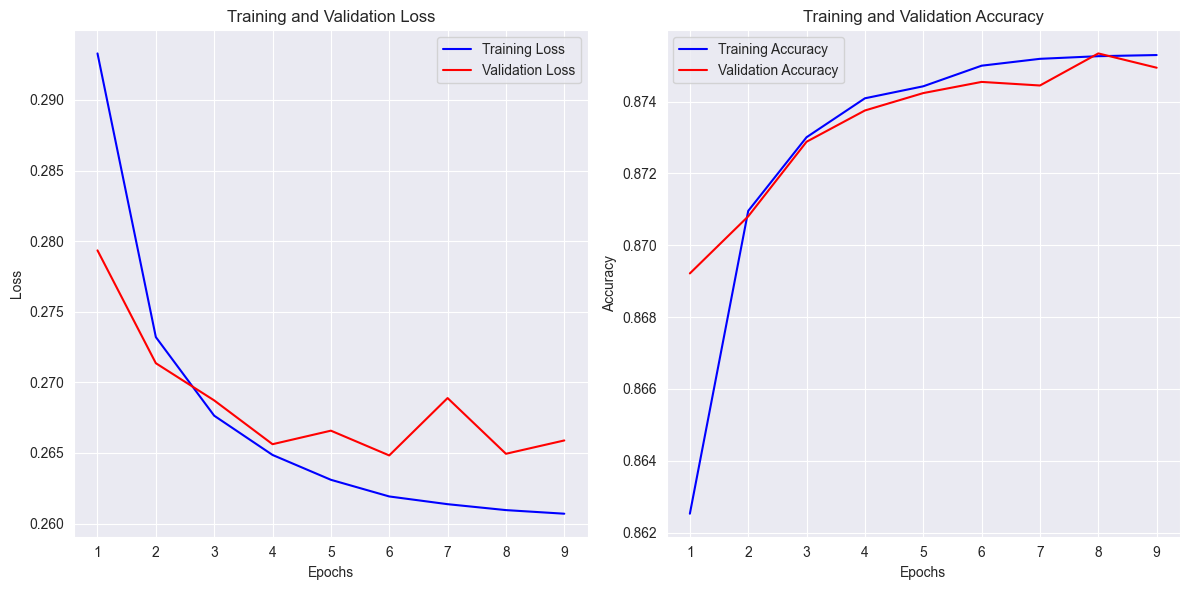

In [139]:
# Access the loss, validation loss, and accuracy from the history object
loss = history_cce.history['loss']
val_loss = history_cce.history['val_loss']
accuracy = history_cce.history['accuracy']
val_accuracy = history_cce.history['val_accuracy']

# Plot the loss, validation loss, and accuracy curves
epochs = range(1, len(loss) + 1)

# Create subplots
fig2, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot loss and validation loss
ax1.plot(epochs, loss, 'b', label='Training Loss')
ax1.plot(epochs, val_loss, 'r', label='Validation Loss')
ax1.set_title('Training and Validation Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()

# Plot accuracy and validation accuracy
ax2.plot(epochs, accuracy, 'b', label='Training Accuracy')
ax2.plot(epochs, val_accuracy, 'r', label='Validation Accuracy')
ax2.set_title('Training and Validation Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()

# Adjust spacing between subplots
plt.tight_layout()

# Show the plots
plt.show()

## Exploring the precursor_charge distribution and adding class weights
might not make sense as there is reason for the "imbalance"

In [83]:
CLASS_NAMES = ["DoubleCharge", "OtherCharges"] # for binary

In [84]:
df_SingleCharges = df_filtered_padded[df_filtered_padded['precursor_charge'] == 1].copy()
df_DoubleCharges = df_filtered_padded[df_filtered_padded['precursor_charge'] == 2].copy()
df_TripleCharges = df_filtered_padded[df_filtered_padded['precursor_charge'] == 3].copy()
df_QuadrupleCharges = df_filtered_padded[df_filtered_padded['precursor_charge'] == 4].copy()
df_QuintupleCharges = df_filtered_padded[df_filtered_padded['precursor_charge'] == 5].copy()
df_SextupleCharges = df_filtered_padded[df_filtered_padded['precursor_charge'] == 6].copy()
df_SeptupleCharges = df_filtered_padded[df_filtered_padded['precursor_charge'] == 7].copy()
# other charges than 2
df_OtherCharges = df_filtered_padded[df_filtered_padded['precursor_charge'] != 2].copy()

COUNT_SingleCharges = len(df_SingleCharges)
COUNT_DoubleCharges = len(df_DoubleCharges)
COUNT_TripleCharges = len(df_TripleCharges)
COUNT_QuadrupleCharges = len(df_QuadrupleCharges)
COUNT_QuintupleCharges = len(df_QuintupleCharges)
COUNT_SextupleCharges = len(df_SingleCharges)
COUNT_SeptupleCharges = len(df_SeptupleCharges)
COUNT_OtherCharges = len(df_OtherCharges)

print("COUNT_SingleCharge: {}".format(COUNT_SingleCharges))
print("COUNT_DoubleCharge: {}".format(COUNT_DoubleCharges))
print("COUNT_TripleCharges:  {}".format(COUNT_TripleCharges))
print("COUNT_QuadrupleCharges: {}".format(COUNT_QuadrupleCharges))
print("COUNT_QuintupleCharges: {}".format(COUNT_QuintupleCharges))
print("COUNT_SextupleCharges: {}".format(COUNT_SextupleCharges))
print("COUNT_SeptupleCharges: {}".format(COUNT_SeptupleCharges))

COUNT_SingleCharge: 999
COUNT_DoubleCharge: 3486981
COUNT_TripleCharges:  1185177
COUNT_QuadrupleCharges: 86471
COUNT_QuintupleCharges: 1694
COUNT_SextupleCharges: 999
COUNT_SeptupleCharges: 1


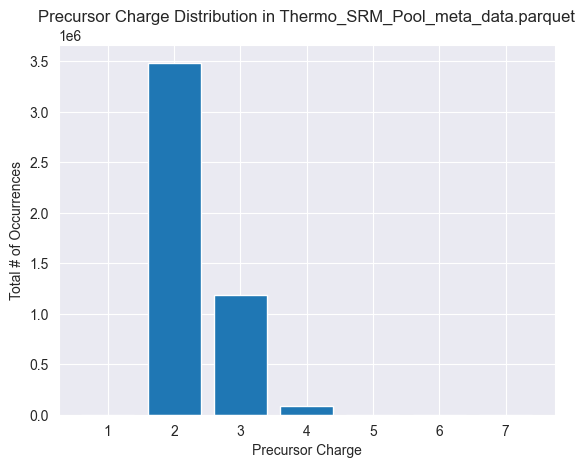

In [154]:
charge_counts = [COUNT_SingleCharges, COUNT_DoubleCharges, COUNT_TripleCharges, COUNT_QuadrupleCharges, COUNT_QuintupleCharges, COUNT_SextupleCharges, COUNT_SeptupleCharges]
charge_labels = ['1', '2', '3', '4', '5', '6', '7']
plt.bar(charge_labels, charge_counts)
plt.title('Precursor Charge Distribution in Thermo_SRM_Pool_meta_data.parquet')
plt.xlabel('Precursor Charge')
plt.ylabel('Total # of Occurrences')
plt.show()

In [86]:
initial_bias = np.log([COUNT_DoubleCharges / COUNT_OtherCharges])
print("Initial bias: {:.5f}".format(initial_bias[0]))

TRAINING_COUNT = COUNT_DoubleCharges + COUNT_OtherCharges
weight_for_other = (1 / COUNT_OtherCharges) * TRAINING_COUNT / 2.0
weight_for_double = (1 / COUNT_DoubleCharges) * TRAINING_COUNT / 2.0

print("weight for Double Charge: {:.2f}".format(weight_for_double))
print("weight for Other Charges: {:.2f}".format(weight_for_other))

Initial bias: 1.00652
weight for Double Charge: 0.68
weight for Other Charges: 1.87


In [87]:
# Calculate class weights
class_labels = np.unique(y_train)
class_weights = class_weight.compute_class_weight('balanced', classes=class_labels, y=y_train)
# Convert class weights to dictionary
class_weights_dict = dict(zip(class_labels, class_weights))
print(class_weights_dict)

{1: 644.9346031746031, 2: 0.19516119590986603, 3: 0.5731295382939475, 4: 7.872167398605011, 5: 403.084126984127, 6: 6219.012244897959, 7: 435330.85714285716}


In [25]:
checkpoint_callback_classweights = ModelCheckpoint('precursor_charge_prediction_model_v1/classweights.h5', monitor='val_accuracy', save_best_only=True, mode='max')

In [26]:
# Train the model with class-weights
weighted_history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test), callbacks=[checkpoint_callback_classweights], class_weight=class_weights_dict) #, wandb_callback])

ValueError: Expected `class_weight` to be a dict with keys from 0 to one less than the number of classes, found {1: 669.3278861360042, 2: 0.1951470232630578, 3: 0.5731530811184621, 4: 7.882430237250256, 5: 416.02719528178244, 6: 6254.753694581281, 7: 544163.5714285715}

### Trying hyperparameter optimization

## Evaluate the models
- confusion matrix
- accuracy
- loss

## Testing the model
- Generate some random sequences
- run them through the model

In [ ]:
# Generate random peptide sequences
num_sequences = 10  # Number of sequences to generate
max_length = 20  # Maximum sequence length
sequences = []
for _ in range(num_sequences):
    length = random.randint(1, max_length)
    sequence = ''.join(random.choices(amino_acids, k=length))
    sequences.append(sequence)

In [42]:
# Convert peptide sequences to numerical representation
def sequence_to_vector(sequence):
    vector = []
    for amino_acid in sequence:
        if amino_acid in amino_acids:
            vector.append(amino_acids.index(amino_acid))
        else:
            vector.append(len(amino_acids))  # Handle unknown amino acids
    return np.array(vector)

# Convert the generated sequences to numerical representation
sequence_vectors = np.array([sequence_to_vector(seq) for seq in sequences])

# Load the trained model
model = tf.keras.models.load_model('precursor_charge_prediction_model_v1')  # Replace with the path to your trained model

# Predict precursor charge for the generated sequences
predictions = model.predict(sequence_vectors)
predicted_charge = np.argmax(predictions, axis=1) + 1

# Display the generated sequences and predicted precursor charge
for sequence, charge in zip(sequences, predicted_charge):
    print('Sequence:', sequence)
    print('Predicted Charge:', charge)
    print('-------------------')